# Diferenciación automática: Parte 2

### NOTA

Este notebook se iniciará en la clase y **debe** hacerse en equipo, con los *mismos miembros* que participaron en la "Tarea4.ipynb". La resolución completa de los ejercicios debe ser enviada como "Tarea5.ipynb".

## Funciones elementales

Lo que se logró en la clase pasada fue, esencialmente, tener una manera de obtener primeras
derivadas para cualquier función racional, esto es, cocientes de polinomios en una variable.

El siguiente paso es incluir más funciones a fin de ampliar la aplicabilidad de lo hecho la vez pasada, en particular a las funciones elementales: $\exp$, $\log$, etc.

La extensión a estas funciones es elemental, y así por ejemplo tenemos:

\begin{eqnarray}
\exp[\vec{f}(x_0)] &=& \big( \exp(f_0),\, f'_0\exp(f_0) \,\big),\\
\log[\vec{f}(x_0)] &=& \big( \log(f_0),\, \frac{f'_0}{f_0} \,\big),\\
\sin[\vec{f}(x_0)] &=& \big( \sin(f_0),\, f'_0\cos(f_0) \,\big),\\
\cos[\vec{f}(x_0)] &=& \big( \cos(f_0),\, -f'_0\sin(f_0) \,\big),\\
\tan[\vec{f}(x_0)] &=& \big( \tan(f_0),\, f'_0\sec^2(f_0) \,\big),\\
\sinh[\vec{f}(x_0)] &=& \big( \sinh(f_0),\, f'_0\cosh(f_0) \,\big),\\
...\\
\end{eqnarray}

Vale la pena enfatizar que la regla de la cadena se utiliza en la segunda componente del 
lado derecho de estas ecuaciones.

## Ejercicio

Implementen las funciones relacionadas con potencias, exponenciales, logarítmos, las funciones trigonométricas y las hiperbólicas que tiene Julia definidas (ver la [documentación](http://julia.readthedocs.org/en/release-0.4/manual/mathematical-operations/#trigonometric-and-hyperbolic-functions)). La implementación debe incluir los tests adecuados. La manera en que implementen las cosas debe estar clara en el notebook "Tarea5.ipynb", pero toda la funcionalidad debe ser incluida en "AutomDiff.jl" al igual que en "runtests.jl"

**Hint:** Aprovechen las capacidades de Julia en metaprogramming.

Primero se limpia el `workspace` para poder regresar y hacer pruebas;

In [1]:
workspace()

Importamos el módulo AD en el archivo AutomDiff.jl y ejecutamos el runtest.jl para ver que funciona nuestro módulo. (En el archivo runtest.jl está la línea importante `using AD`).

In [2]:
include("AutomDiff.jl")
include("runtest.jl")

Después importamos las funciones que vamos a utilizar y definimos sencillamente el método para la exponencial y su derivada.

In [3]:
import Base: exp, log, sin, cos, tan, sinh, cosh, tanh, asin, 
            acos, atan, asinh, acosh, atanh
exp(a::Dual) = Dual(exp(a.fun),a.der*exp(a.fun))

exp (generic function with 13 methods)

Como cálculo explícito, se calcula la derivada de $\exp(x^2)$:

In [4]:
exp(xdual(1.0)^2).der

5.43656365691809

In [5]:
@test exp(xdual(1.0)^2).der == 2exp(1.0)

Como se puede ver, funciona bien. Ahora definimos una lista de tuplas llamada `oper` que contiene la expresión por una parte y por otra parte la derivada. En muchos casos conviene utilizar funciones anónimas para no tener problemas en escribir los símbolos de por ejemplo, $\frac{1}{1+x^2}$.

In [6]:
oper = [(:exp, :exp), (:log, :inv), (:sin, :cos), (:cos, :(x -> -sin(x))),
    (:tan, x -> (sec(x))^2), (:sinh, :cosh), (:cosh, :sinh),
    (:tanh, x -> (sinh(x))^2),(:asin, x -> 1/sqrt(1-x^2)), (:acos, x -> -1/sqrt(1-x^2)),
    (:atan, x -> 1/(1+x^2)), (:asinh, x -> 1/sqrt(x^2+1)), 
    (:acosh, x -> 1/(sqrt(x-1)sqrt(x+1))), (:atanh, x -> 1/(1-x^2))];

Ahora simplemente iteramos sobre esta lista y usando `quote` generamos el código para las distitnas funciones en `oper`.

In [7]:
for (f,fd) in oper # f es la función y fd la derivada
    ex = quote
        function  ($f)(a::Dual) # Aquí se define el método f para una dual
            fu = ($f)(a.fun) # Sabemos que la primera entrada de la dual
            # es la misma función.
            de = a.der*($fd)(a.fun) # Para la derivada, tenemos la regla de
            # la cadena que nos dice que mulipliquemos la derivada de la dual
            # que estamos metiendo por la fd correspondiente valuada en a.fun
            return Dual(fu, de)
        end
    end
    @eval $ex # Evaluamos cada una de las expresiones que formamos.
end

Se hacen una serie de pruebas, mismas que están incluidas en el archivo runtest.jl

In [8]:
@test cos(xdual(pi)).der == -sin(pi)

In [9]:
@test sinh(xdual(pi)).der == cosh(pi)

In [35]:
@test exp(log(xdual(1.0))).der == xdual(1.0).der

In [45]:
@test (cos(xdual(2))^2).der+((sin(xdual(2)))^2).der ==0

## Ejercicio

Prueben su implementación calculando la derivada de $f(x) = \sin\Big(x^3 - \frac{2}{x^6}\Big)$
en $x_0 = 2$.

Dibujen, para $x_0 \in [1,5]$ la función $f'(x)$.

Definimos a función:

In [11]:
f(x) = sin(x^3 -2/x^6)

f (generic function with 1 method)

Con lo trabajado en el ejercicio anterior podemos calcular la dual directamente.

In [12]:
f(xdual(2))

AD.Dual{Float64}(0.9934213368955197,-1.384934905523464)

Hacemos la prubea de que la derivada sea correcta:

In [13]:
@test f(xdual(2)).der == cos(2.^3-2./2.^6)*(3*2.^2+12./2.^7)

Importamos PyPlot y hacemos arreglos que nos permiten graficar 1000 puntos entre (1,5). El arreglo `y` se construye punto a punto para evitar vectorizar las funciones. Ésto porque aunque se pudo vectorizar `xdual` no se pudo vectorizar f.

In [14]:
using PyPlot

In [15]:
x = linspace(1,5,1000);

In [16]:
y = zeros(Float64, 1000);

In [17]:
i = 1 
for j in x # Se construye el arreglo y con las derivadas simplemente 
    # iterando sobre el linspace x.
    y[i] = f(xdual(j)).der
    i = i + 1
end

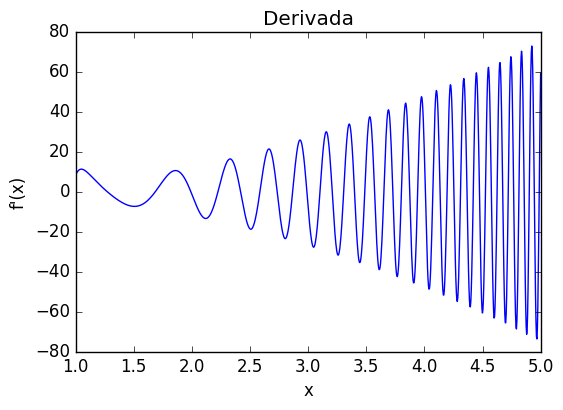

In [18]:
fig = figure("pyplot", figsize = (6,4))
a = plot(x,y)
title("Derivada")
xlabel("x")
ylabel("f'(x)")
xlim(1,5)
show()

# Ejercicio

Implementen el método de Newton para una función arbitraria $f(x)$ en una variable (la función `newton1D` debe tener un argumento que es una función) a fin de encontrar un cero de la función, i.e., $f(x^*)=0$. El método de Newton requiere la derivada evaluada en diversos puntos, cosa que obtendrán usando el módulo de derivación automática.

- Obtengan, usando su función del método de Newton, las raices del polinomio de Wilkinson $W_{6}(x)$, usando como iterados iniciales $x_0=2.2$ y $x_0=2.45$.
    
- Hagan lo mismo que en el inciso anterior para $g(x) = x \sin(2x)$, con $x_0=0.7$.

Se define el polinomio de Wilkinson:

In [19]:
W6(x) = (x-1)*(x-2)*(x-3)*(x-4)*(x-5)*(x-6)

W6 (generic function with 1 method)

Su derivada seríá simplemente:

In [20]:
dW6(x) = W6(xdual(x)).der

dW6 (generic function with 1 method)

La función `compute_roots` calcula las raíces de una función utilizando veinte iteraciones del método de Newton.

In [21]:
function compute_roots(f::Function, df::Function,x::Real)
    # 20 iterations of Newton's method
    for i in 1:20
        x = x - f(x) / df(x)
    end
    return x
end

compute_roots (generic function with 1 method)

Así, la raíz del polinomio con $x_0 = 2.2$ es:

In [22]:
compute_roots(W6, dW6, 2.2)

2.0

En cambio, con $x_0 =2.45$ es:

In [23]:
compute_roots(W6, dW6, 2.45)

6.0

La raíz de $x \sin(2x)$ con $x_0 =0.7$ es prácticamente un cero:

In [24]:
compute_roots(x -> x*sin(2*x), x-> (xdual(x)*sin(2*xdual(x))).der, 0.7)

2.5539099419345546e-7

Graficamos esta función:

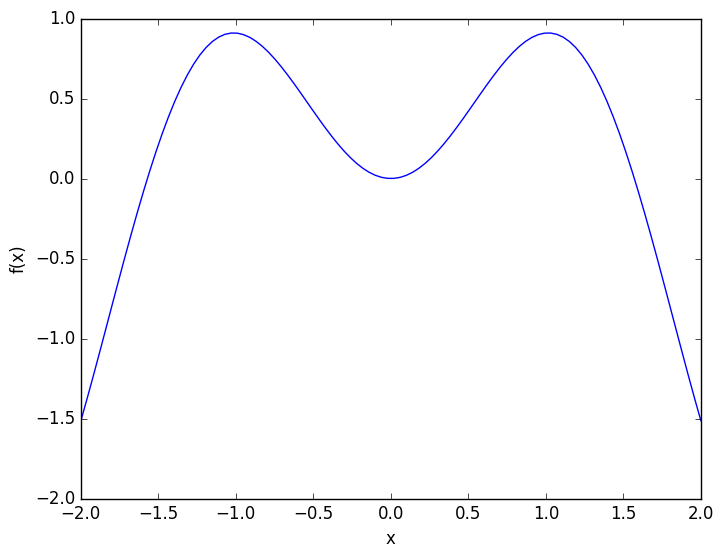

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fa6442a1090>

In [34]:
figure()
x = linspace(-2,2,100)
xlabel("x")
ylabel("f(x)")
b = plot(x,x.*sin(2x))

Se ve que hay una raíz cercana a $x_0 = 1.5$:

In [26]:
compute_roots(x -> x*sin(2*x), x-> (xdual(x)*sin(2*xdual(x))).der, 1.5)

1.5707963267948966

# Pregunta

¿Qué hacer si se requieren derivadas de orden superior, es decir, la segunda, tercera, etc, derivada? Argumenten.

**NOTA:** Esta pregunta debe ser contestada pero **no** será considerada para aceptar la tarea; la idea es empezar a pensar en esto.

Lo que uno pensaría inicialmente es que sí se puede hacer sencillamente. Ponemos la función $f(x) = x^2$:

In [27]:
f(x) = x^2
typeof(f)

Function

Por ejemplo:

In [28]:
f(2)

4

Ahora, su derivada la podemos definir como lo hicimos en los ejercicios anteriores:

In [29]:
df(x) = f(xdual(x)).der; typeof(df)

Function

Y se ve claro que  la derivada calcula bien:

In [30]:
df(2)

4

Ahora queremos definir la segunda derivada de la manera análoga:

In [31]:
ddf(x) = df(xdual(x)).der

ddf (generic function with 1 method)

Pero no funciona:

In [32]:
ddf(2)

LoadError: LoadError: StackOverflowError:
while loading In[32], in expression starting on line 1

Específicamente no funciona ni siquiera la estrucutra de la dual:

In [33]:
df(xdual(2.))

LoadError: LoadError: StackOverflowError:
while loading In[33], in expression starting on line 1

Lo que está sucediendo es que el álgebra que definimos para los duales no se puede aplicar para sacar duales de la derivada porque esta derivada no tiene una estructura algebraica. Es decir, por haber extraído la derivada de la primera dual no nos traemos la estructura algebraica de la derivada. Lo que quiere decir es que df(x) aunque tiene los valores de $2x$ no tiene la estructura algebraica para poder meterla en otra dual y sacarle su derivada.